In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

sys.path.append(os.path.join(Path().resolve(), '../../../../..'))

import numpy as np
from tqdm import tqdm

import hydra
from omegaconf import DictConfig, OmegaConf
import torch


/home/docker/.pyenv/versions/3.8.0/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 勾配を計算しない
torch.set_grad_enabled(False)

In [3]:
%matplotlib inline
# %matplotlib notebook
# %matplotlib nbagg
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation

import numpy as np
from tqdm import tqdm

In [4]:
model_folder = "results/RSSM-seed_0/2022-10-11/run_0"

In [5]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
with initialize(config_path=model_folder):
    cfg = compose(config_name="hydra_config")

# cfg_device = "cuda:0"
cfg_device = "cpu"
cfg.main.device = cfg_device
# cfg.train.n_episode = 100
print(' ' * 26 + 'Options')
for k, v in cfg.items():
    print(' ' * 26 + k + ': ' + str(v))

device = torch.device(cfg.main.device)

                          Options
                          main: {'experiment_name': 'RSSM-seed_0', 'tags': ['RSSM'], 'log_dir': '/home/docker/sharespace/for_public/gitlab/multimodal-rssm/train/COBOTTA/SingleHoleDrilling/MRSSM/MRSSM/results/RSSM-seed_0/2022-10-11/run_0', 'seed': 0, 'disable_cuda': False, 'device': 'cpu', 'wandb': True, 'git_hash': 'bd11f1f'}
                          env: {'env_config': {'env_name': 'SingleHoleDrilling'}, 'taskset_name': 'cobotta', 'observation_shapes': {'image_horizon': [3, 64, 64], 'image_horizon_64': [3, 64, 64], 'image_horizon_128': [3, 128, 128], 'image_horizon_256': [3, 256, 256], 'image_horizon_64_bin': [1, 64, 64], 'image_horizon_128_bin': [1, 128, 128], 'image_horizon_256_bin': [1, 256, 256], 'image_vertical_64': [3, 64, 64], 'image_vertical_128': [3, 128, 128], 'image_vertical_256': [3, 256, 256], 'image_vertical_64_bin': [1, 64, 64], 'image_vertical_128_bin': [1, 128, 128], 'image_vertical_256_bin': [1, 256, 256], 'weight_value': [1], 'weig

/tmp/ipykernel_2579311/6472675.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path=model_folder):


# Load Model, Data and States

In [6]:
import glob
model_paths = glob.glob(os.path.join(model_folder, '*.pth'))
print("model_pathes: ")
model_paths

model_pathes: 


['results/RSSM-seed_0/2022-10-11/run_0/models_1000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_2000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_3000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_4000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_5000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_6000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_7000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_8000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_9000.pth',
 'results/RSSM-seed_0/2022-10-11/run_0/models_10000.pth']

In [7]:
model_idx = -1

from algos.MRSSM.MRSSM.algo import build_RSSM

model = build_RSSM(cfg, device)
model_path = model_paths[model_idx]
model.load_model(model_path)
model.eval()

Multimodal RSSM (MoPoE)
load model_dicts from results/RSSM-seed_0/2022-10-11/run_0/models_10000.pth


In [8]:
use_validation_data = False

In [9]:
from algos.MRSSM.MRSSM.train import get_dataset_loader

cwd = "."
if use_validation_data:
    D = get_dataset_loader(cfg, cwd, device, cfg.train.validation_data_path)
else:
    D = get_dataset_loader(cfg, cwd, device, cfg.train.train_data_path)


load dataset from ./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train
find 20 npy files!


load dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 163.36it/s]

set color augment params
calc pca from torch.Size([90, 3, 64, 64]) data


# Reconstruction

In [10]:
from utils.evaluation.estimate_states import get_episode_data

epi_idx = 0
crop_idx = 0
observations, actions, rewards, nonterminals = get_episode_data(D, epi_idx=epi_idx, crop_idx=crop_idx)

In [12]:
observations.keys()

dict_keys(['sound', 'image_horizon'])

In [13]:
for name in observations.keys():
    if "image_horizon" in name:
        if "bin" in name:
            image_name_horizon_bin = name
        else:
            image_name_horizon = name
    if "image_vertical" in name:
        if "bin" in name:
            image_name_vertical_bin = name
        else:
            image_name_vertical = name

In [14]:
size = (256,256)
size = (64,64)

In [15]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### get PCA result

In [17]:
from utils.evaluation.visualize_utils import get_pca_model, tensor2np, get_xyz

#### <span style="color: red; ">please run estimate_state.py for estimate states of train dataset</span>

In [18]:
# load states
state_path = model_path.replace("models", "states_models").replace(".pth", ".npy")
print("state_path:", state_path)

states_np = np.load(state_path, allow_pickle=True).item()
print("-- dataset --")
for key in states_np.keys():
    print(key)

print("-- key of states --")
print(states_np[key].keys())

state_path: results/RSSM-seed_0/2022-10-11/run_0/states_models_10000.npy
-- dataset --
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-52-36.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-34-24.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-36-45.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-50-03.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-32-07.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-09-11-09.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-24-02.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-56-49.npy
./../../../../../dataset/COBOTTA/SingleHoleDrilling/dataset/train/cobotta_2022-05-29-08-26-46.npy
./../../../../../dataset/COBOTT

In [19]:
ht = [states_np[key]["beliefs"] for key in states_np.keys()]
ht = np.vstack(ht)
pca_ht = get_pca_model(ht)

(8947, 1024)


In [20]:
st_q = [states_np[key]["posterior_means"] for key in states_np.keys()]
st_q = np.vstack(st_q)
pca_st_q = get_pca_model(st_q)

(8947, 128)


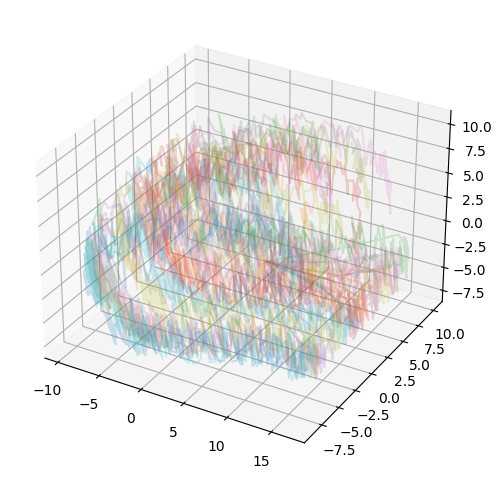

In [21]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

for key in states_np.keys():
    ht = states_np[key]["beliefs"]
    shape = ht.shape[-1]
    feat = tensor2np(ht).reshape(-1, shape)
    feat_pca = pca_ht.transform(feat)
    x, y, z = get_xyz(feat_pca)
    ax.plot(x, y, z, alpha=0.2)
    # ax.scatter(x, y, z, alpha=0.2)
plt.show()



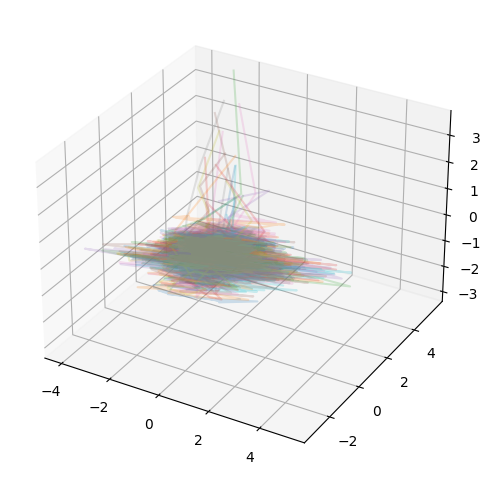

In [22]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

for key in states_np.keys():
    st_q = states_np[key]["posterior_means"]
    shape = st_q.shape[-1]
    feat = tensor2np(st_q).reshape(-1, shape)
    feat_pca = pca_st_q.transform(feat)
    x, y, z = get_xyz(feat_pca)
    ax.plot(x, y, z, alpha=0.2)
    # ax.scatter(x, y, z, alpha=0.2)
plt.show()



### reconstruction result

In [23]:
observations_target = model._clip_obs(observations, idx_start=1)
state = model.estimate_state(observations_target, actions[:-1], rewards, nonterminals[:-1])

In [24]:
state.keys()

dict_keys(['beliefs', 'prior_states', 'prior_means', 'prior_std_devs', 'posterior_states', 'posterior_means', 'posterior_std_devs', 'expert_means', 'expert_std_devs'])

In [25]:
# recon = model.rssm.observation_model(h_t=state["beliefs"], s_t=state["posterior_states"])
recon = model.observation_model(h_t=state["beliefs"], s_t=state["posterior_means"])
recon.keys()

dict_keys(['image_horizon', 'sound'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [00:00<00:00, 5531.73it/s]


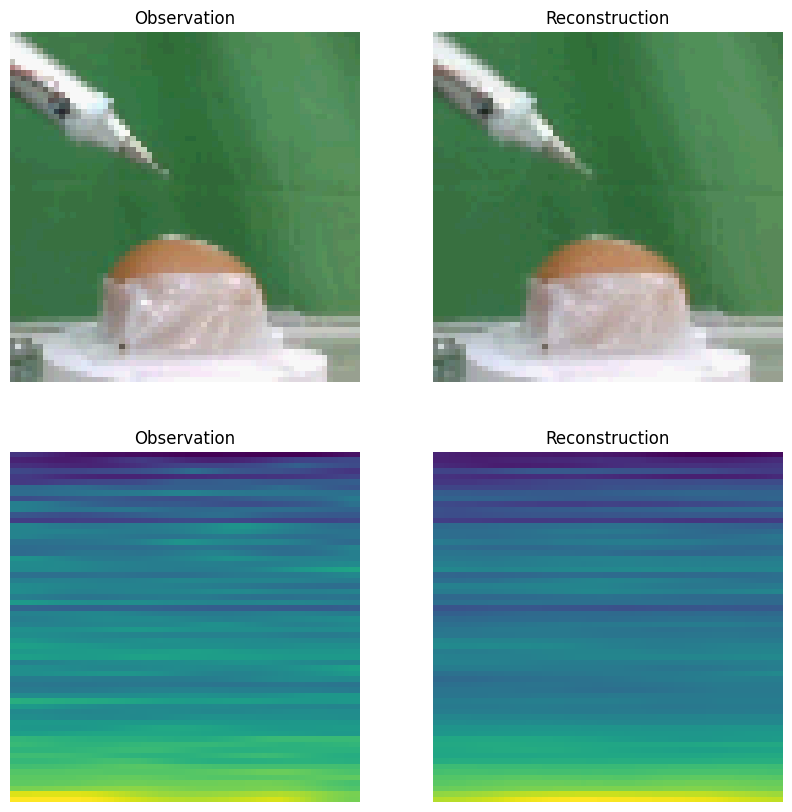

fin


In [26]:
import cv2
from utils.evaluation.visualize_utils import reverse_image_observation
from IPython import display
import mpl_toolkits

h_graph = 2
w_graph = 2
fig = plt.figure(figsize=(w_graph*5,h_graph*5))
ax1 = fig.add_subplot(h_graph, w_graph, 1)
ax2 = fig.add_subplot(h_graph, w_graph, 2)
ax3 = fig.add_subplot(h_graph, w_graph, 3)
ax4 = fig.add_subplot(h_graph, w_graph, 4)

n_frame = len(recon[image_name_horizon]["loc"])

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

dt = 1
size = (64,64)
artists = []
for t in range(0, n_frame, dt):
    im = observations[image_name_horizon][t, 0][[2,1,0]].detach().cpu().numpy()
    im = reverse_image_observation(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im1 = ax1.imshow(im)
    ax1.set_title("Observation")
    
    im = recon[image_name_horizon]["loc"][t, 0][[2,1,0]].detach().cpu().numpy()
    im = reverse_image_observation(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im2 = ax2.imshow(im)
    ax2.set_title("Reconstruction")
    
    im = observations["sound"][t, 0].detach().cpu().numpy()
    # im = image_postprocess(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im3 = ax3.imshow(im)
    ax3.set_title("Observation")
    
    im = recon["sound"]["loc"][t, 0].detach().cpu().numpy()
    # im = image_postprocess(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im4 = ax4.imshow(im)
    ax4.set_title("Reconstruction")
    
    
    artists.append([im1,im2,im3,im4])

# 4. アニメーション化
anim = ArtistAnimation(fig, tqdm(artists), interval=100*dt)

if use_validation_data:
    folder_name = "figs/validation"
else:
    folder_name = "figs/train"

os.makedirs(folder_name, exist_ok=True)
save_file_name = "{}/reconstruction_ep{}.mp4".format(folder_name, epi_idx)
anim.save(save_file_name, writer='ffmpeg')
plt.show()

print("fin")

In [27]:
expert_means = state["expert_means"]
expert_std_devs = state["expert_std_devs"]

In [28]:
prior_means = state["prior_means"][:,0].detach().cpu().numpy()
prior_std_devs = state["prior_std_devs"][:,0].detach().cpu().numpy()

posterior_means = state["posterior_means"][:,0].detach().cpu().numpy()
posterior_std_devs = state["posterior_std_devs"][:,0].detach().cpu().numpy()

In [29]:
expert_means = dict()
expert_std_devs = dict()
for name in state["expert_means"].keys():
    expert_means[name] = state["expert_means"][name][:,0].detach().cpu().numpy()
    expert_std_devs[name] = state["expert_std_devs"][name][:,0].detach().cpu().numpy()

In [30]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
expert_colors = dict()
keys = list(expert_means.keys())
for i in range(len(keys)):
    expert_colors[keys[i]] = colors[i+2]

In [31]:
expert_means.keys()

dict_keys(['prior_expert', 'image_horizon', 'sound'])

In [32]:
expert_means["prior_expert"].shape[1]

128

In [33]:
from utils.models.encoder import calc_subset_states

In [34]:
subset_means, subset_std_devs = calc_subset_states(state["expert_means"], state["expert_std_devs"])

In [35]:
len(subset_means)

4

# Imagination

In [36]:
t_imag_start = 20

h_t = [state["beliefs"][t_imag_start]]
# s_t = [state["posterior_states"][t_imag_start]]
s_t = [state["posterior_means"][t_imag_start]]

t_max = len(actions)
horizon_imagination = t_max-t_imag_start
for t in range(horizon_imagination):
    belief, _, prior_mean, _ = model.transition_model(s_t[t], actions[t_imag_start+t].unsqueeze(dim=0), h_t[t], det=True)
    h_t.append(belief.squeeze(dim=0))
    # st.append(prior_state.squeeze(dim=0))
    s_t.append(prior_mean.squeeze(dim=0))

In [37]:
h_t = torch.stack(h_t)
s_t = torch.stack(s_t)


In [38]:
recon_imag = model.observation_model(h_t=h_t, s_t=s_t)
# recon_imag["image_vertical_high_resolution"]["loc"].shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 423/423 [00:00<00:00, 5177.00it/s]


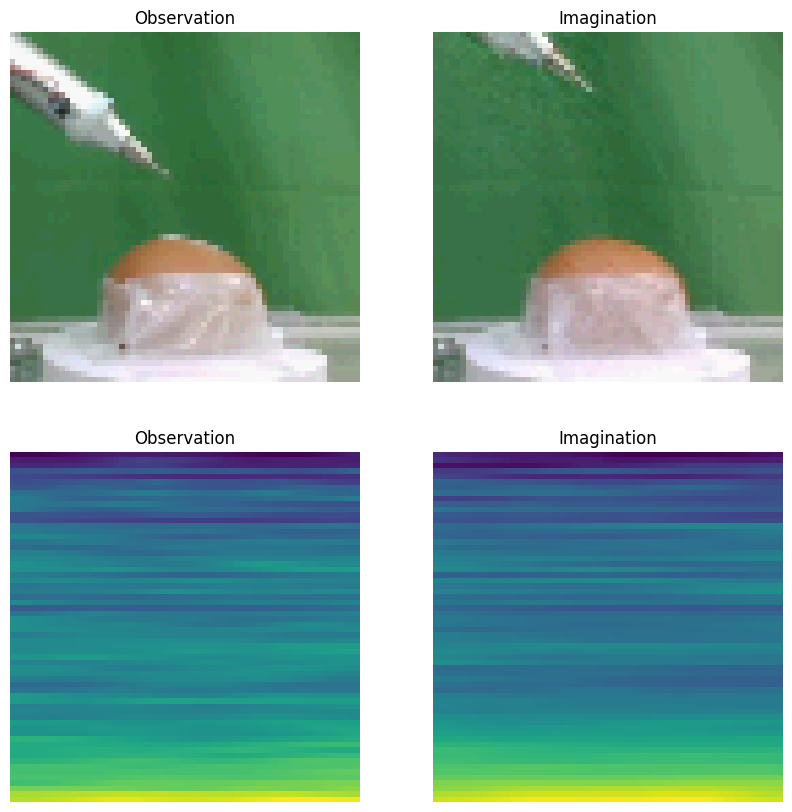

fin


In [39]:
import cv2
from utils.evaluation.visualize_utils import reverse_image_observation
from IPython import display
import mpl_toolkits

h_graph = 2
w_graph = 2
fig = plt.figure(figsize=(w_graph*5,h_graph*5))
ax1 = fig.add_subplot(h_graph, w_graph, 1)
ax2 = fig.add_subplot(h_graph, w_graph, 2)
ax3 = fig.add_subplot(h_graph, w_graph, 3)
ax4 = fig.add_subplot(h_graph, w_graph, 4)

n_frame = horizon_imagination

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

dt = 1
size = (64,64)
artists = []
for t in range(0, n_frame, dt):
    t_obs = t_imag_start+t
    
    if t_obs >= len(observations[image_name_horizon]):
        t_obs = len(observations[image_name_horizon])-1
    
    im = observations[image_name_horizon][t_obs, 0][[2,1,0]].detach().cpu().numpy()
    im = reverse_image_observation(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im1 = ax1.imshow(im)
    ax1.set_title("Observation")
    
    im = recon_imag[image_name_horizon]["loc"][t, 0][[2,1,0]].detach().cpu().numpy()
    im = reverse_image_observation(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im2 = ax2.imshow(im)
    ax2.set_title("Imagination")
    
    im = observations["sound"][t_obs, 0].detach().cpu().numpy()
    # im = image_postprocess(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im3 = ax3.imshow(im)
    ax3.set_title("Observation")
    
    im = recon_imag["sound"]["loc"][t, 0].detach().cpu().numpy()
    # im = image_postprocess(im)
    im = cv2.resize(im, size, interpolation=cv2.INTER_LINEAR)
    im4 = ax4.imshow(im)
    ax4.set_title("Imagination")
    
    
    artists.append([im1,im2,im3,im4])

# 4. アニメーション化
anim = ArtistAnimation(fig, tqdm(artists), interval=100*dt)

if use_validation_data:
    folder_name = "figs/validation"
else:
    folder_name = "figs/train"

os.makedirs(folder_name, exist_ok=True)
save_file_name = "{}/imagination_ep{}.mp4".format(folder_name, epi_idx)
anim.save(save_file_name, writer='ffmpeg')
plt.show()

print("fin")